# Convolutional Neural Networks
- CIFAR-10 image classification with CNN
  - Last time, we have attempted to classify images in the CIFAR-10 dataset with MLP and deeper MLP. The final results were accuracy scores of 0.369 and 0.504, respectively.
  - Let's try to improve the classification performance by implementing simple CNN

In [ ]:
!pip3 install torch torchvision
!pip install ipdb

In [11]:
import numpy as np
import pandas as pd
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import ipdb

## 1. Import & process dataset
- CIFAR10 dataset can be downloaded by ```torchvision```
  - [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

train_dataset = datasets.CIFAR10(root = "/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "/", train = False, download = True, transform = transforms.ToTensor())

50000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32])
3  -  cat
(32, 32, 3)


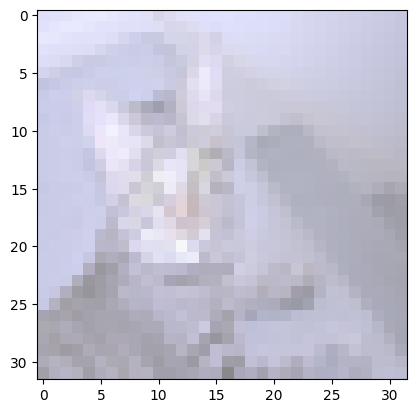

In [40]:
import random
print(len(train_dataset))
print(train_dataset.classes)
img, label = train_dataset[random.randint(0,len(train_dataset))]
#print(img)
print(img.shape)
print(label,' - ', train_dataset.classes[label])

import matplotlib.pyplot as plt
img0 = torchvision.utils.make_grid(img)
img1 = img0 / 2 + 0.5
img2 = img1.numpy()
img3 = np.transpose(img2, (1,2,0))
print(img3.shape)
plt.imshow(img3)


## 2. Creating CNN model and training

- Create and train simple CNN model

![](https://www.researchgate.net/profile/Qianzhou_Du2/publication/322477802/figure/fig3/AS:582461356511232@1515881017676/Illustration-of-Convolutional-Neural-Network-CNN-Architecture.png)

In [5]:
# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [6]:
# create CNN with one convolution/pooling layer
class net(nn.Module):
  def __init__(self, input_dim, num_filters, kernel_size, stride, padding, num_classes):
    super(net, self).__init__()
    self.input_dim = input_dim
    conv_output_size = int((input_dim - kernel_size + 2 * padding)/stride) + 1   # conv layer output size
    pool_output_size = int((conv_output_size - kernel_size)/stride) + 1          # pooling layer output size

    self.conv = nn.Conv2d(3, num_filters, kernel_size = kernel_size, stride = stride, padding = padding)
    self.pool = nn.MaxPool2d(kernel_size = kernel_size, stride = stride)
    self.relu = nn.ReLU()
    self.dense = nn.Linear(pool_output_size * pool_output_size * num_filters, num_classes)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)   # resize to fit into final dense layer
    x = self.dense(x)
    return x

In [7]:
# hyperparameters
DEVICE = torch.device('cuda')
INPUT_DIM = 32
NUM_FILTERS = 32
KERNEL_SIZE = 3
STRIDE = 1
PADDING = 1
NUM_CLASSES = 10
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30

In [8]:
model = net(INPUT_DIM, NUM_FILTERS, KERNEL_SIZE, STRIDE, PADDING, NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()   # do not need softmax layer when using CEloss criterion
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [9]:
# training for NUM_EPOCHS
for i in range(NUM_EPOCHS):
  temp_loss = []
  for (x, y) in train_loader:
    x, y = x.float().to(DEVICE), y.to(DEVICE)
    outputs = model(x)
    loss = criterion(outputs, y)
    temp_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Loss at {}th epoch: {}".format(i, np.mean(temp_loss)))

Loss at 0th epoch: 1.5712974797124448
Loss at 1th epoch: 1.1810427417840494
Loss at 2th epoch: 1.0656654142662692
Loss at 3th epoch: 0.9980279734677366
Loss at 4th epoch: 0.9477736516986661
Loss at 5th epoch: 0.9076264293297477
Loss at 6th epoch: 0.8745927472248711
Loss at 7th epoch: 0.8494284117923063
Loss at 8th epoch: 0.8183362279706599
Loss at 9th epoch: 0.7914504044501068


KeyboardInterrupt: ignored

## 3. Evaluation
- Evaluate the trained CNN model with accuracy score
  - Store probability of each instance to a list and compare it with true y label

In [ ]:
y_pred, y_true = [], []
with torch.no_grad():
  for x, y in test_loader:
    x, y = x.float().to(DEVICE), y.to(DEVICE)
    outputs = F.softmax(model(x)).max(1)[-1]       # predicted label
    y_true += list(y.cpu().numpy())                # true label
    y_pred += list(outputs.cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [ ]:
# evaluation result
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6454